In [1]:
from __future__ import division

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import roc_curve, auc

import scipy.io as sio

### Helper fcns

In [2]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, norm=True):

    if norm:
        totals = cmat.sum(axis=1)
        totals = totals.T
        totals = np.expand_dims(totals,axis=1)
        totals = np.tile(totals,(1,2))
        cmat_norm = cmat/totals
        print cmat_norm
        cm = cmat_norm

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Non-Fall','Fall'], rotation=45)
    plt.yticks(tick_marks, ['Non-Fall','Fall'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-2-1476b93d3700>, line 11)

In [56]:
def LOSOCV(X,y):

    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]
    thr = np.linspace(0,1,21)
    thr = thr[::-1]

    plt.figure(figsize=(8,6))

    for train_index, test_index in subj.split(X, y, groups):

        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]

        #selct features
        Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]

        forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)    
        forest.fit(Xtr,ytr)
        ypred = forest.predict(Xte)
        yscore = forest.predict_proba(Xte)
        yscore = yscore[:,1]

        #acc = np.sum(ypred==yte)/len(ypred)
        #print('Acc = %.4f')%acc

    #    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1,drop_intermediate=False
        #compute ROC at fixed thresholds (to plot error bars)
        fpr=np.linspace(0,1,101); tpr=[]
        nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
        neg_counts = sum(yte==0)
        for f in fpr:
            ind = neg_counts-int(neg_counts*f)-1
            t = (nscores[ind])[0]
            if f==1:
                t = 0
            tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
            tpr.append(tpr_t) 

        t=.5
        #compute Sens and Spec
        Sens = sum((ypred==1) & (yte==1)) / sum(yte==1); Spec = 1-sum((ypred==1) & (yte==0)) / sum(yte==0)

        fpr = np.asarray(fpr); tpr = np.asarray(tpr)
        roc_auc = auc(fpr, tpr)
        print('AUC = %.4f, Sens = %.4f, Spec = %.4f'%(roc_auc,Sens,Spec))    
        AUC_all.append(roc_auc)
        tpr_all.append(tpr); fpr_all=fpr;
        Sens_all.append(Sens); Spec_all.append(Spec)

        #plot each individual ROC
    #     lw = 2
    #     plt.plot(fpr, tpr, color='darkorange',
    #              lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    #     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    # plt.xlim([-0.05, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Healthy-Healthy')
    #plt.legend(loc="lower right")

    #summary results
    print(('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all)))
    print(('mean Sens = %.3f (+/- %0.3f)')%(np.mean(Sens_all),2*np.std(Sens_all)))
    print(('mean Spec = %.3f (+/- %0.3f)')%(np.mean(Spec_all),2*np.std(Spec_all)))

    return AUC_all, fpr_all, tpr_all, Sens_all, Spec_all

In [66]:
def plot_roc(tpr_all,fpr,roc_auc):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    ax = sns.tsplot(data=tpr,time=fpr)
    lw = 3
    ax.plot(fpr, tprmu, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

In [27]:
def ThresholdClass(TrainData,TestData):
    """Inputs: Dataframe containing AccMax and AccMin accelerations for both train and test data
    Outputs: dataframe of classification of test data as fall (True) or non-fall (False)"""
    Max = TrainData.AccMax
    Min = TrainData.AccMin
    UFT = Max[Healthy.Falltype==1].min(axis=0)
    LFT = Min[Healthy.Falltype==1].max(axis=0)
    
    return (TestData.AccMax>UFT) & (TestData.AccMin<LFT)

    

### Load the data

In [6]:
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})

In [7]:
#Subjtype: 0 = Amputee, 1 = Healthy , 2 = Healthy outdoor
Healthy.head(5)

,SubjID,Loc,Subjtype,Falltype,4,5,6,7,8,9,...,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214
0,1,1,1,3,-0.135490,0.023986,-0.22209,-0.034934,0.026296,0.061168,...,1.3975,1.0539,1.371,0.57013,0.042151,0.040205,0.036391,0.082633,0.057698,0.142730
1,1,1,1,3,-0.116930,0.041788,-0.25966,-0.036706,0.028857,0.069082,...,1.0056,-1.0666,1.371,0.59226,0.044890,0.055954,0.064699,0.077030,0.105940,0.130800
2,1,1,1,3,-0.095297,-0.009186,-0.26274,-0.031153,0.019380,0.071339,...,1.5987,2.0886,1.371,0.76639,0.050949,0.099145,0.054502,0.070348,0.107280,0.145240
3,1,1,1,4,-0.131590,0.012601,0.36066,-0.030360,0.038864,0.070713,...,2.0909,4.4104,1.371,0.51069,0.035452,0.046974,0.043586,0.073470,0.071604,0.098844
4,1,1,1,4,-0.174220,0.002581,0.33938,-0.049466,0.017201,0.068173,...,2.0293,4.1421,1.371,0.50332,0.045742,0.077608,0.067755,0.079449,0.131450,0.085266


In [8]:
print len(Healthy)
print len(Amp)

SyntaxError: invalid syntax (<ipython-input-8-562b20fddae7>, line 1)

In [9]:
print ('N subjects Healthy: %s'%(len(Healthy.SubjID.unique())))
print ('N subjects Amp: %s'%(len(Amp.SubjID.unique())))
print Healthy.Subjtype.unique()
print Amp.Subjtype.unique()

SyntaxError: invalid syntax (<ipython-input-9-1c308cac9380>, line 3)

In [11]:
#Healthy
print ('Nfalls = %s')%(len(Healthy[Healthy.Falltype<9]))
print ('Nactivities = %s')%(len(Healthy[Healthy.Falltype==9]))

Nfalls = 6337
Nactivities = 315


In [12]:
#Amp
print ('Nfalls = %s')%(len(Amp[Amp.Falltype<9]))
print ('Nactivities = %s')%(len(Amp[Amp.Falltype==9]))

Nfalls = 1873
Nactivities = 307


In [10]:
#selecting cols by index
Healthy.iloc[1:5, 0:4]

,SubjID,Loc,Subjtype,Falltype
1,1,1,1,3
2,1,1,1,3
3,1,1,1,4
4,1,1,1,4


# Train on healthy and test on amputees

In [11]:
#transform to binary class
Xtr = Healthy.iloc[:,4:].as_matrix()
ytr = Healthy.Falltype.as_matrix()
Xte = Amp.iloc[:,4:].as_matrix()
yte = Amp.Falltype.as_matrix()
ytr[ytr < 9] = 1
ytr[ytr == 9] = 0
yte[yte < 9] = 1
yte[yte == 9] = 0

In [15]:
print Xtr.shape
print np.unique(ytr)
print Xte.shape
print np.unique(yte)

(6652, 1211)
[0 1]
(2180, 1211)
[0 1]


In [12]:
forest = RandomForestClassifier(n_estimators=50,random_state=10)
forest.fit(Xtr,ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [13]:
importance = forest.feature_importances_
print(importance)
indices = np.argsort(importance)
importance_std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
print(importance_std)

[  1.85748464e-04   2.16391737e-04   8.30112513e-04 ...,   0.00000000e+00
   7.37234140e-04   6.20178579e-05]
[ 0.00074738  0.001124    0.00298893 ...,  0.          0.00300895
  0.00043413]


In [14]:
importance_norm = importance/np.max(importance)

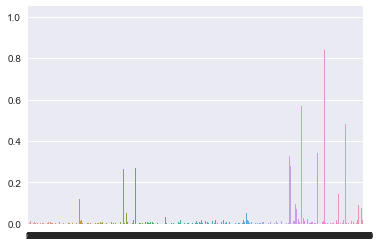

In [15]:
#using Seaborn
ax = sns.barplot(x=indices,y=importance_norm[indices])
sns.set_context("paper")
plt.figure(figsize=(8,6))

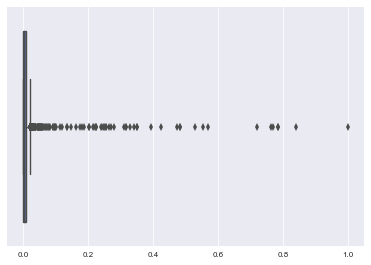

In [16]:
ax = sns.boxplot(importance_norm)
plt.figure(figsize=(8,6))

In [17]:
qc = np.percentile(importance_norm,[75])
print 1.5*qc

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-17-e9c628b8fdb5>, line 2)

In [20]:
# indmax = np.argwhere(importance_norm >= 1.5*qc)
indmax = np.argwhere(importance_norm >= 0.1)
indmax = indmax.reshape(-1)
print(len(indmax))
print(indmax)

47
[ 183  184  185  338  344  386  387  388  423  445  470  492  520  569  570
  599  785  786  940  945  946  948  956  957  972  986  988  989  990  996
 1018 1046 1047 1048 1070 1071 1072 1120 1121 1122 1144 1145 1146 1147 1190
 1195 1200]


In [21]:
forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)
forest.fit(Xtr[:,indmax],ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [22]:
ypred = forest.predict(Xte[:,indmax])
yscore = forest.predict_proba(Xte[:,indmax])
yscore = yscore[:,1]

In [23]:
#acc = np.sum(ypred==yte)/len(ypred)
#print('Acc = %.3f')%acc
fprHA, tprHA, thresholdsHA = metrics.roc_curve(yte, yscore, pos_label=1)
roc_aucHA = auc(fprHA, tprHA)
print('AUC = %.3f'%roc_aucHA)

AUC = 0.991


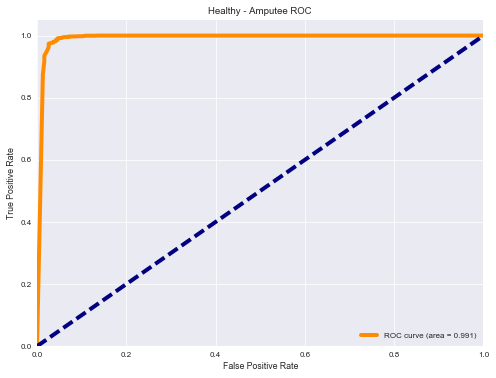

In [24]:
plt.figure(figsize=(8,6))
lw = 4
plt.plot(fprHA, tprHA, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_aucHA)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy - Amputee ROC')
plt.legend(loc="lower right")
sns.set_context('poster')

### Threshold Method

In [28]:
Healthy = Healthy.rename(index=int,columns={950:'AccMax',951:'AccMin'})
Amp = Amp.rename(index=int,columns={950:'AccMax',951:'AccMin'})
ThresPred = ThresholdClass(Healthy,Amp)

In [29]:
Sens = len(ThresPred[(ThresPred==True) & (Amp.Falltype==1)])/len(ThresPred[Amp.Falltype==1])
Spec = len(ThresPred[(ThresPred==False) & (Amp.Falltype==0)])/len(ThresPred[Amp.Falltype==0])

print (Sens)
print (Spec)

1.0
0.18892508143322476


# LOSO CV on Healthy

In [30]:
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})

In [31]:
from sklearn.model_selection import LeaveOneGroupOut

In [33]:
#Subjects with indoor and outdoor falls
print(np.sort(Healthy[Healthy.Subjtype == 1].SubjID.unique()))
print(np.sort(Healthy[Healthy.Subjtype == 2].SubjID.unique()))

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  4  5  6  7  8  9 10]


In [34]:
#drop subject 3 (does not have outdoor falls)
Healthy = Healthy[Healthy.SubjID!=3]
Healthy.SubjID.unique()

array([ 1,  2,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [35]:
Healthy.shape

(6236, 1215)

In [36]:
#binarize labels
X = Healthy.iloc[:,4:].as_matrix()
y = Healthy.Falltype.as_matrix()
y[y < 9] = 1
y[y == 9] = 0

In [37]:
np.unique(y)

array([0, 1], dtype=int64)

In [65]:
print X.shape
print y.shape

(6236, 1211)
(6236,)


In [38]:
groups = Healthy.SubjID.as_matrix()
print(groups.shape)
print(np.unique(groups))

(6236,)
[ 1  2  4  5  6  7  8  9 10]


In [39]:
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

9

In [40]:
indmax #602 gyro features + 602 accelerometer

array([ 183,  184,  185,  338,  344,  386,  387,  388,  423,  445,  470,
        492,  520,  569,  570,  599,  785,  786,  940,  945,  946,  948,
        956,  957,  972,  986,  988,  989,  990,  996, 1018, 1046, 1047,
       1048, 1070, 1071, 1072, 1120, 1121, 1122, 1144, 1145, 1146, 1147,
       1190, 1195, 1200], dtype=int64)

In [42]:
#sanity check
for train_index, test_index in subj.split(X, y, groups):
    Xtr,Xte = X[train_index],X[test_index]
    ytr = y[train_index]
    Xtr,Xte = Xtr[:,indmax],Xte[:,indmax]
    print(Xtr.shape,Xte.shape,ytr.shape)

(5540, 47) (696, 47) (5540,)
(5549, 47) (687, 47) (5549,)
(5680, 47) (556, 47) (5680,)
(5504, 47) (732, 47) (5504,)
(5502, 47) (734, 47) (5502,)
(5529, 47) (707, 47) (5529,)
(5614, 47) (622, 47) (5614,)
(5460, 47) (776, 47) (5460,)
(5510, 47) (726, 47) (5510,)


In [57]:
AUC_all, fpr_all, tpr_all, Sens_all, Spec_all = LOSOCV(X,y)

AUC = 0.9993, Sens = 0.9985, Spec = 0.9583
AUC = 0.9862, Sens = 0.9851, Spec = 0.7333
AUC = 0.9999, Sens = 1.0000, Spec = 0.9444
AUC = 0.9991, Sens = 1.0000, Spec = 0.8333
AUC = 0.9989, Sens = 1.0000, Spec = 0.9429
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 0.9941, Sens = 0.9986, Spec = 0.8493
AUC = 0.9995, Sens = 0.9899, Spec = 0.9722
mean AUC = 0.997 (+/- 0.009)
mean Sens = 0.997 (+/- 0.010)
mean Spec = 0.915 (+/- 0.170)


In [46]:
AUC_all

[0.99926339285714283,
 0.98620535714285718,
 0.9998977695167286,
 0.99906944444444445,
 0.99892703862660948,
 1.0,
 1.0,
 0.9940967283072546,
 0.99952173913043474]

In [58]:
fpr_all

array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
        0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
        0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
        0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
        0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
        0.54,  0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,
        0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,
        0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,
        0.81,  0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,
        0.9 ,  0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,
        0.99,  1.  ])

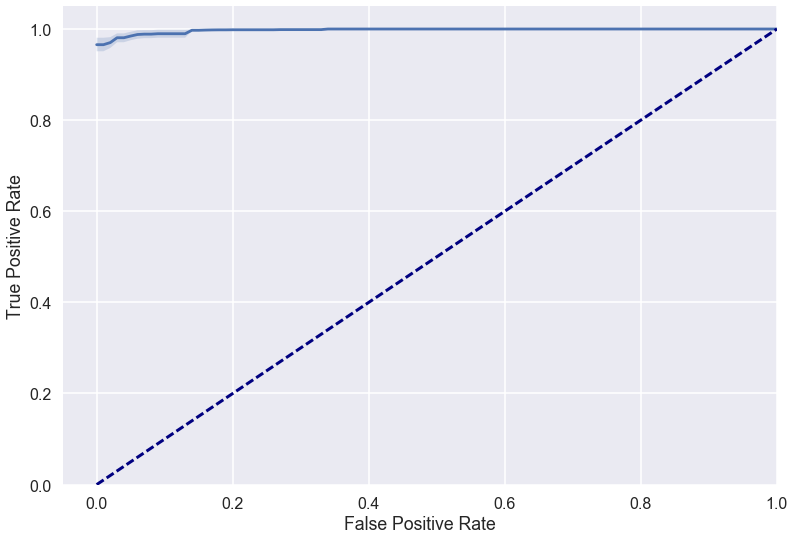

In [67]:
plot_roc(tpr_all,fpr_all,np.mean(AUC_all))

# LOSO CV on Amputees

**Note: SubjID 2 does not have activities** (Nick please check)
**Need to load each time the file because after binarizing the labels in previous steps the original table are changed. Should be fixed**

In [68]:
Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})

In [69]:
Amp[Amp.SubjID ==2].Falltype.unique()

array([4, 3, 2, 1], dtype=int64)

In [70]:
Amp = Amp[Amp.SubjID != 2] #drop subj 2

In [74]:
X = Amp.iloc[:,4:].as_matrix()
y = Amp.Falltype.as_matrix()
y[y < 9] = 1
y[y == 9] = 0
groups = Amp.SubjID.as_matrix()
print(groups.shape)
print(np.sort(np.unique(groups)))
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

(1840,)
[1 3 4 5 6 7]


6

In [75]:
groups = Amp.SubjID.as_matrix()
print(groups.shape)
print(np.unique(groups))
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

(1840,)
[1 3 4 5 6 7]


6

In [76]:
#sanity check
for train_index, test_index in subj.split(X, y, groups):
    Xtr,Xte = X[train_index],X[test_index]
    ytr = y[train_index]
    Xtr,Xte = Xtr[:,indmax],Xte[:,indmax]
    print(Xtr.shape,Xte.shape,ytr.shape)

(1578, 47) (262, 47) (1578,)
(1431, 47) (409, 47) (1431,)
(1446, 47) (394, 47) (1446,)
(1569, 47) (271, 47) (1569,)
(1732, 47) (108, 47) (1732,)
(1444, 47) (396, 47) (1444,)


In [77]:
AUC_all_AA, fpr_all_AA, tpr_all_AA, Sens_all_AA, Spec_all_AA = LOSOCV(X,y)

AUC = 0.9933, Sens = 0.9641, Spec = 0.9744
AUC = 0.9782, Sens = 1.0000, Spec = 0.9365
AUC = 0.9998, Sens = 1.0000, Spec = 0.9767
AUC = 0.9884, Sens = 0.9721, Spec = 0.8750
AUC = 0.9926, Sens = 0.8636, Spec = 1.0000
AUC = 0.9850, Sens = 1.0000, Spec = 0.9531
mean AUC = 0.990 (+/- 0.014)
mean Sens = 0.967 (+/- 0.097)
mean Spec = 0.953 (+/- 0.080)


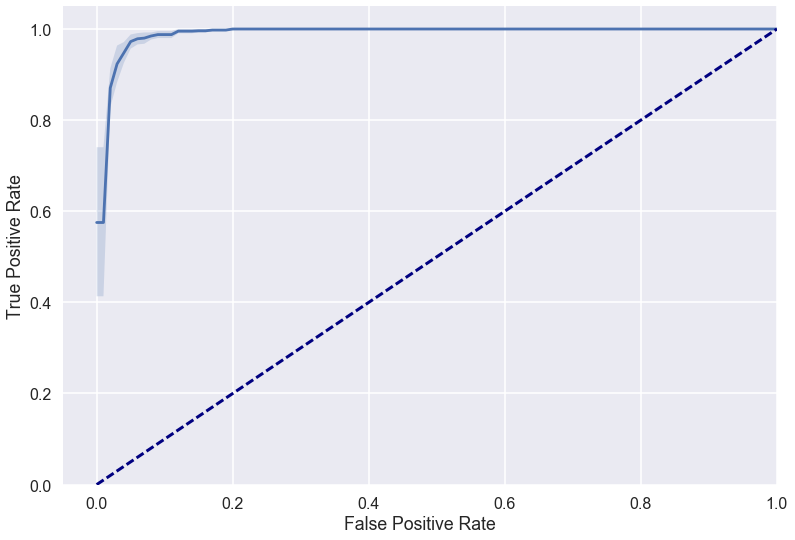

In [78]:
plot_roc(tpr_all_AA,fpr_all_AA,np.mean(AUC_all_AA))

# Misc stuff to clean later

In [ ]:
AUC_all = []

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    #selct features
    #Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]
    
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)    
    forest.fit(Xtr,ytr)
    ypred = forest.predict(Xte)
    yscore = forest.predict_proba(Xte)
    yscore = yscore[:,1]
    acc = np.sum(ypred==yte)/len(ypred)
    #print('Acc = %.4f')%acc
    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f'%roc_auc)    
    AUC_all.append(roc_auc)  
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Amputees - Random forest')
plt.legend(loc="lower right")

In [ ]:
#LOSO CV
AUC_all = []

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    #selct features
    Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]

    xgb1.fit(Xtr,ytr)
    ypred = xgb1.predict(Xte)
    yscore = xgb1.predict_proba(Xte)
    yscore = yscore[:,1]
    acc = np.sum(ypred==yte)/len(ypred)
#    print('Acc = %.4f')%acc
    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f'%roc_auc)    
    AUC_all.append(roc_auc)  
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy - XGboost forest')
plt.legend(loc="lower right")

In [ ]:
print('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all))

See here on XGBoost params
http://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters

as well as here
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
xgb1.get_params()

In [ ]:
xgb1.fit(Xtr,ytr,eval_metric='auc')

In [ ]:
pred = xgb1.predict(Xte)

In [ ]:
pred_prob = xgb1.predict_proba(Xte)

In [ ]:
pred_prob.shape

In [ ]:
X = Xin.drop(['SubjID','Loc','Subjtype'],axis=1)
X.head(3)

In [ ]:
xgtrain = xgb.DMatrix(X,label='Falltype')
xgtest = xgb.DMatrix(Xte,label='Falltype')

In [ ]:
print xgtrain.num_col()
print xgtrain.num_row()
print xgtest.num_col()
print xgtest.num_row()

Look at the clips

In [ ]:
labels = sio.loadmat('./Data/accHealthy10.mat')

In [ ]:
acc = labels['acc']

In [ ]:
acc.shape

In [ ]:
i

In [ ]:
i = np.random.permutation(fpidx4)
i = i[0]
a = acc[i][0][:,1:]
plt.plot(a)

In [ ]:
np.where(Healthy.Falltype == 0)

In [ ]:
acc